In [1]:
# Batchly calculate absolute magnitudes of the unLRG samples

In [2]:
import os
import numpy as np
import pandas as pd
import utils_sdss as utils

In [3]:
# load data
# load the unLRG sample list
listpath = "./BH_SDSS_cross_checked.xlsx"
data = pd.read_excel(listpath, "Sheet2")

In [4]:
extinction_u = data["extinction_u"]
extinction_g = data["extinction_g"]
extinction_r = data["extinction_r"]
extinction_i = data["extinction_i"]
extinction_z = data["extinction_z"]

cmodelmag_u = np.nan_to_num(data["cmodelmag_u"])
cmodelmag_g = np.nan_to_num(data["cmodelmag_g"])
cmodelmag_r = np.nan_to_num(data["cmodelmag_r"])
cmodelmag_i = np.nan_to_num(data["cmodelmag_i"])
cmodelmag_z = np.nan_to_num(data["cmodelmag_z"])

cmodelmagerr_u = np.nan_to_num(data["cmodelmagerr_u"])
cmodelmagerr_g = np.nan_to_num(data["cmodelmagerr_g"])
cmodelmagerr_r = np.nan_to_num(data["cmodelmagerr_r"])
cmodelmagerr_i = np.nan_to_num(data["cmodelmagerr_i"])
cmodelmagerr_z = np.nan_to_num(data["cmodelmagerr_z"])

In [192]:
# exclude bad sample
idx_u1 = np.where(cmodelmag_u != -9999)[0]
idx_u2 = np.where(cmodelmag_u != 0.0)[0]
idx_u3 = np.where(cmodelmag_u != 10000)[0]
idx = np.intersect1d(idx_u1,idx_u2)
idx = np.intersect1d(idx, idx_u3)

In [6]:
# Calc parameters and save
redshift = data["z"]
params = np.zeros((len(redshift),11))
fp = open("params_unLRG.dat","w")
for i in idx:
    z = redshift[i]
    mags = [cmodelmag_u[i],cmodelmag_g[i],cmodelmag_r[i],cmodelmag_r[i],cmodelmag_z[i]]
    exts = [extinction_u[i],extinction_g[i],extinction_r[i],extinction_r[i],extinction_z[i]]
    magerrs = [cmodelmagerr_u[i],cmodelmagerr_g[i],cmodelmagerr_g[i],cmodelmagerr_i[i],cmodelmagerr_z[i]]
    params[i,:] = utils.get_sample_params(mags,exts,magerrs,z)
    for param in params[i,:]:
        fp.write(str(param))
        fp.write(" ")
    fp.write("\n")
fp.close()

In [7]:
# Get coeffs and kcorrection
parampath = "params_unLRG.dat"
coeffpath = "coeff_unLRG.dat"
reconpath = "reconf_unLRG.dat"
utils.calc_reconmag_batch(parampath, coeffpath, reconpath)

In [8]:
# load reconstruct k_correction
with open("./reconf_unLRG.dat", 'r') as fp:
    reconmags = fp.readlines()

In [9]:
# calc absolute magnitudes and save into excels
mag_abs = np.ones((len(redshift),))*10000
for j,i in enumerate(idx):
    z = redshift[i]
    dl = utils.calc_luminosity_distance(z) # luminosity distance [Mpc]
    mags = [cmodelmag_u[i],cmodelmag_g[i],cmodelmag_r[i],cmodelmag_r[i],cmodelmag_z[i]]
    exts = [extinction_u[i],extinction_g[i],extinction_r[i],extinction_r[i],extinction_z[i]]
    reconmag = reconmags[j].split(" ")
    mag_abs[i] = utils.calc_absmag(mags[2]-exts[2],dl.value,float(reconmag[3]))

## Plot the 2D maps

In [10]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
%matplotlib inline

In [193]:
mode = data["Type"]
idx1 = np.where(mode == 1)[0]
idx2 = np.where(mode == 2)[0]
idx3 = np.where(mode == 3)[0]
idx4 = np.where(mode == 4)[0]
idx5 = np.where(mode == 5)[0]
idx6 = np.where(mode == 6)[0]

In [194]:
idx2_same = np.intersect1d(idx,idx2)
idx3_same = np.intersect1d(idx,idx3)

In [195]:
flux = data["S_nvss"]
lumo = utils.flux_to_luminosity(redshift = redshift, flux = flux)

In [196]:
from scipy.optimize import curve_fit
def gauss(x, a, c, mu, sigma):
    return a*np.exp(-(x-mu)**2/sigma**2)+c

## Typical FR

In [197]:
lumo_fr1_typical = lumo[idx2_same] * 10**-22
[num_fr1_typical,edge_fr1_typical] = np.histogram(np.log10(lumo_fr1_typical), bins=np.arange(1,6,0.2))

In [198]:
lumo_fr2_typical = lumo[idx3_same] * 10**-22
[num_fr2_typical,edge_fr2_typical] = np.histogram(np.log10(lumo_fr2_typical), bins=np.arange(1,6,0.2))

In [199]:
mag_fr1_typical = mag_abs[idx2_same]
mag_fr2_typical = mag_abs[idx3_same]

## BT

In [200]:
BT = data["BT"]
idx_fr1 = np.where(BT == 1)[0]
idx_fr2 = np.where(BT == 2)[0]
idx_fr1 = np.intersect1d(idx, idx_fr1)
idx_fr2 = np.intersect1d(idx, idx_fr2)

In [201]:
lumo_fr1_like = lumo[idx_fr1] * 10**-22
[num_fr1_like,edge_fr1_like] = np.histogram(np.log10(lumo_fr1_like), bins=np.arange(1,6,0.2))

In [202]:
lumo_fr2_like = lumo[idx_fr2] * 10**-22
[num_fr2_like,edge_fr2_like] = np.histogram(np.log10(lumo_fr2_like), bins=np.arange(1,6,0.2))

In [203]:
mag_fr1_like = mag_abs[idx_fr1]
mag_fr2_like = mag_abs[idx_fr2]

## typical FR + BT

In [204]:
mag_fr1 = np.hstack([mag_abs[idx_fr1], mag_abs[idx2_same]])
mag_fr2 = np.hstack([mag_abs[idx_fr2], mag_abs[idx3_same]])
lumo_fr1 = np.hstack([lumo[idx_fr1], lumo[idx2_same]]) * 10 ** -22
lumo_fr2 = np.hstack([lumo[idx_fr2], lumo[idx3_same]]) * 10 ** -22

In [205]:
# histogram and curvefitting
[num_fr1,edge_fr1] = np.histogram(np.log10(lumo_fr1), bins=np.arange(1,6,0.2))
[num_fr2,edge_fr2] = np.histogram(np.log10(lumo_fr2), bins=np.arange(1,6,0.2))

## Compare curves

In [206]:
from imp import reload
reload(utils)

<module 'utils_sdss' from '/home/mzx/work/sync/writings/ApJ-RGClassificationAndSimulation/presentations/seminar-171101/utils_sdss.py'>

In [207]:
x_fr1_t,y_fr1_t = utils.draw_step(num_fr1_typical,edge_fr1_typical)
x_fr2_t,y_fr2_t = utils.draw_step(num_fr2_typical,edge_fr2_typical)

In [208]:
x_fr1_l,y_fr1_l = utils.draw_step(num_fr1_like,edge_fr1_like)
x_fr2_l,y_fr2_l = utils.draw_step(num_fr2_like,edge_fr2_like)

In [209]:
x_fr1,y_fr1 = utils.draw_step(num_fr1,edge_fr1)
x_fr2,y_fr2 = utils.draw_step(num_fr2,edge_fr2)

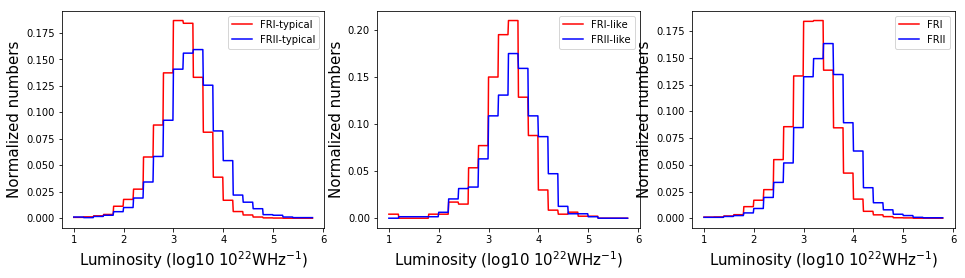

In [225]:
plt.rcParams["figure.figsize"] = [16.0, 4.0]
plt.subplot(131)
plt.plot(x_fr1_t, y_fr1_t, 'r')
plt.plot(x_fr2_t, y_fr2_t, 'b')
plt.legend(["FRI-typical","FRII-typical"])
plt.ylabel("Normalized numbers", fontsize=15)
plt.xlabel("Luminosity (log10 $10^{22} \mathrm{W} \mathrm{Hz}^{-1}$)",fontsize=15)
plt.subplot(132)
plt.plot(x_fr1_l, y_fr1_l, 'r')
plt.plot(x_fr2_l, y_fr2_l, 'b')
plt.legend(["FRI-like","FRII-like"])
plt.ylabel("Normalized numbers", fontsize=15)
plt.xlabel("Luminosity (log10 $10^{22} \mathrm{W} \mathrm{Hz}^{-1}$)",fontsize=15)
plt.subplot(133)
plt.plot(x_fr1, y_fr1, 'r')
plt.plot(x_fr2, y_fr2, 'b')
plt.legend(["FRI","FRII"])
plt.ylabel("Normalized numbers", fontsize=15)
plt.xlabel("Luminosity (log10 $10^{22} \mathrm{W} \mathrm{Hz}^{-1}$)",fontsize=15)

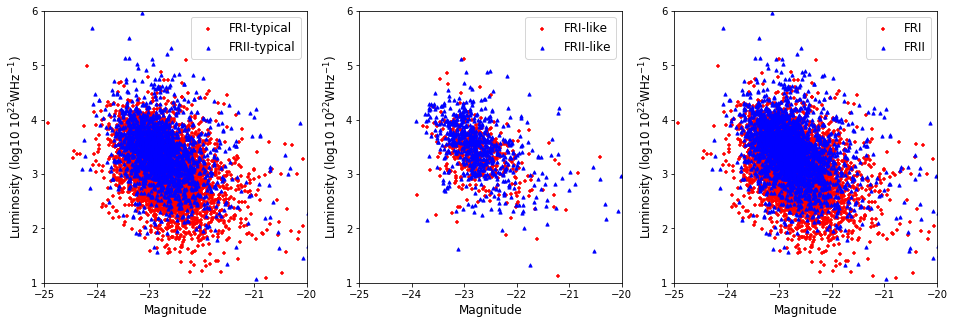

In [211]:
plt.rcParams["figure.figsize"] = [16.0, 5.0]
plt.subplot(131)
plt.scatter(mag_fr1_typical,np.log10(lumo_fr1_typical),c='r',marker='+',s=10)
plt.scatter(mag_fr2_typical,np.log10(lumo_fr2_typical),c='b',marker='^',s=10)
plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}$)",fontsize=12)
plt.xlabel("Magnitude",fontsize=12)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(("FRI-typical","FRII-typical"),fontsize=12)

plt.subplot(132)
plt.scatter(mag_fr1_like,np.log10(lumo_fr1_like),c='r',marker='+',s=10)
plt.scatter(mag_fr2_like,np.log10(lumo_fr2_like),c='b',marker='^',s=10)
plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}$)",fontsize=12)
plt.xlabel("Magnitude",fontsize=12)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(("FRI-like","FRII-like"),fontsize=12)

plt.subplot(133)
plt.scatter(mag_fr1,np.log10(lumo_fr1),c='r',marker='+',s=10)
plt.scatter(mag_fr2,np.log10(lumo_fr2),c='b',marker='^',s=10)
plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}$)",fontsize=12)
plt.xlabel("Magnitude",fontsize=12)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(("FRI","FRII"),fontsize=12)

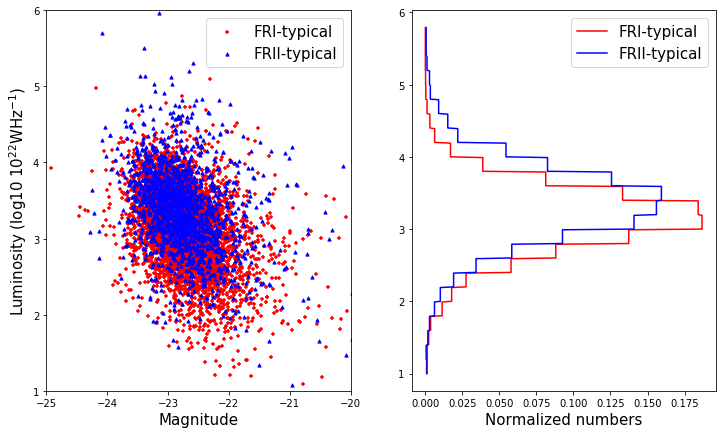

In [224]:
plt.rcParams["figure.figsize"] = [12.0, 7.0]
plt.subplot(121)
plt.scatter(mag_fr1_typical,np.log10(lumo_fr1_typical),c='r',marker='+',s=10)
plt.scatter(mag_fr2_typical,np.log10(lumo_fr2_typical),c='b',marker='^',s=10)
plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}$)",fontsize=15)
plt.xlabel("Magnitude",fontsize=15)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(("FRI-typical","FRII-typical"),fontsize=15)

plt.subplot(122)
plt.plot(y_fr1_t, x_fr1_t, 'r')
plt.plot(y_fr2_t, x_fr2_t, 'b')
plt.legend(["FRI-typical","FRII-typical"],fontsize=15)
plt.xlabel("Normalized numbers", fontsize=15)
# plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W} \mathrm{Hz}^{-1}$)",fontsize=12)

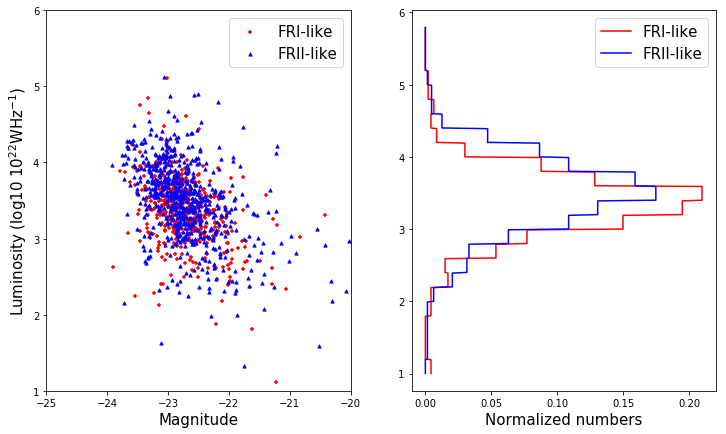

In [226]:
plt.rcParams["figure.figsize"] = [12.0, 7.0]
plt.subplot(121)
plt.scatter(mag_fr1_like,np.log10(lumo_fr1_like),c='r',marker='+',s=10)
plt.scatter(mag_fr2_like,np.log10(lumo_fr2_like),c='b',marker='^',s=10)
plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}$)",fontsize=15)
plt.xlabel("Magnitude",fontsize=15)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(("FRI-like","FRII-like"),fontsize=15)

plt.subplot(122)
plt.plot(y_fr1_l, x_fr1_l, 'r')
plt.plot(y_fr2_l, x_fr2_l, 'b')
plt.legend(["FRI-like","FRII-like"],fontsize=15)
plt.xlabel("Normalized numbers", fontsize=15)
# plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W} \mathrm{Hz}^{-1}$)",fontsize=12)

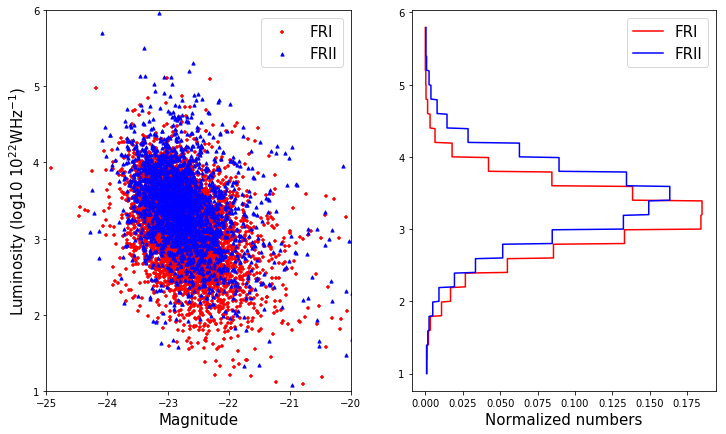

In [223]:
plt.rcParams["figure.figsize"] = [12.0, 7.0]
plt.subplot(121)
plt.scatter(mag_fr1,np.log10(lumo_fr1),c='r',marker='+',s=10)
plt.scatter(mag_fr2,np.log10(lumo_fr2),c='b',marker='^',s=10)
plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}$)",fontsize=15)
plt.xlabel("Magnitude",fontsize=15)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(("FRI","FRII"),fontsize=15)

plt.subplot(122)
plt.plot(y_fr1, x_fr1, 'r')
plt.plot(y_fr2, x_fr2, 'b')
plt.legend(["FRI","FRII"],fontsize=15)
plt.xlabel("Normalized numbers", fontsize=15)
# plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W} \mathrm{Hz}^{-1}$)",fontsize=12)